# 7.1 언어 모델을 사용한 문장 생성

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from common.rnnlm import Rnnlm
from common.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_idx =None, sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) <sample_size:
            x=np.array(x).reshape(1,1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size = 1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        
        return word_ids

In [2]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt =' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you coup indianapolis bork leftist contracted worsen experiencing secured columns announce sun mid-1980s predictions pressured pound dialing bothered kuala vietnamese involvement it bausch disappear knight-ridder renewing died euphoria balked single-a-1 watched reportedly blunt deduction advertised italian hyundai dictaphone return drama fresenius one jose levine fox shirts automated proposing plans reuter education propaganda unrest dig fall spate voted kent discovision listed salt destroyed complete individual lehman permissible roebuck hospitals 'll digs tool parking modifications resolve possibility redmond ind. combination pursue gte clean-air cards grasp guest combines universal potatoes merger referred celebration cycling recommendations script freedoms illegal time software conversations colombian publisher


In [3]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt =' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you need to though the largest bell sooner russian animals do news.
 mr. roman had been vague with the chairman.
 mr. jones says.
 despite the vote that mr. roman 's nightmare were n't yet.
 he told ford however john c. fargo 's two on oct..
 insisting for example says it will take in an recruiting technique requiring a complex financial services unit a series of east germany 's own account.
 the machinists follows the company is valued at least four quarters of share.
 had plummeted an important interest to reduce costs to the


In [4]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_idx =None, sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) <sample_size:
            x=np.array(x).reshape(1,1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size = 1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        
        return word_ids

In [5]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params('BetterRnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt =' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you would go moving to black to manipulate i would like to have our people he said.
 there 's a question of people and be the theory for me says that is for deals.
 state law is on himself.
 senate activist jefferson mitchell jr. that oversees an unprecedented restraint line in protest for assassinations is pursuing california.
 the public is contingent at implement a barrel of u.s. aid spending and if those who think they hire tourists have resumed their own teams.
 a vote to red tape will create a thin surplus of about one-third


In [6]:
model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

the meaning of life is free to shut down the shopping center.
 under the latest part of the junk-bond market it has avoided since september this year and the supercomputer company league export debt market declined per total of mortgage use the money.
 a spokeswoman for the first time in the last week drexel and a unit of firstsouth 's various brokerage firms presumed real-estate houses also failed to qualify for packaged goods.
 this has asked to be limited in the early 1980s but can choose to close 's value value and strategy.
 world investigators worry that that bad advertising


# 7.2 seq2seq

In [7]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed = 22)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[4 2 8 9 1 5 5]
[6 8 0 0 5]
5+206  
_211 


# 7.3 seq2seq 구현

In [8]:
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.86
| epoch 1 |  iter 121 / 351 | time 3[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 4[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 5[s] | loss 1.81
| epoch 1 |  iter 181 / 351 | time 6[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 7[s] | loss 1.78
| epoch 1 |  iter 221 / 351 | time 8[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 9[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 10[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 11[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 13[s] | loss 1.75
| epoch 1 |  iter 321 / 351 | time 14[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 16[s] | loss 1.74
Q 207+640
T 847 
X 1000
---
Q 694+544
T 1238
X 1000
---
Q 86+687 

| epoch 7 |  iter 321 / 351 | time 17[s] | loss 1.03
| epoch 7 |  iter 341 / 351 | time 18[s] | loss 1.05
Q 207+640
T 847 
X 827 
---
Q 694+544
T 1238
X 1207
---
Q 86+687 
T 773 
X 770 
---
Q 575+15 
T 590 
O 590 
---
Q 909+60 
T 969 
X 965 
---
Q 56+918 
T 974 
X 965 
---
Q 38+792 
T 830 
X 827 
---
Q 58+421 
T 479 
X 480 
---
Q 122+89 
T 211 
X 207 
---
Q 636+200
T 836 
X 827 
---
val acc 4.380%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 1.02
| epoch 8 |  iter 21 / 351 | time 1[s] | loss 1.04
| epoch 8 |  iter 41 / 351 | time 2[s] | loss 1.03
| epoch 8 |  iter 61 / 351 | time 2[s] | loss 1.03
| epoch 8 |  iter 81 / 351 | time 3[s] | loss 1.03
| epoch 8 |  iter 101 / 351 | time 4[s] | loss 1.02
| epoch 8 |  iter 121 / 351 | time 5[s] | loss 1.01
| epoch 8 |  iter 141 / 351 | time 6[s] | loss 1.02
| epoch 8 |  iter 161 / 351 | time 7[s] | loss 1.02
| epoch 8 |  iter 181 / 351 | time 8[s] | loss 1.01
| epoch 8 |  iter 201 / 351 | time 9[s] | loss 1.02
| epoch 8 |  iter 221 / 351 | tim

| epoch 14 |  iter 141 / 351 | time 7[s] | loss 0.84
| epoch 14 |  iter 161 / 351 | time 8[s] | loss 0.84
| epoch 14 |  iter 181 / 351 | time 9[s] | loss 0.83
| epoch 14 |  iter 201 / 351 | time 10[s] | loss 0.85
| epoch 14 |  iter 221 / 351 | time 11[s] | loss 0.84
| epoch 14 |  iter 241 / 351 | time 12[s] | loss 0.86
| epoch 14 |  iter 261 / 351 | time 13[s] | loss 0.87
| epoch 14 |  iter 281 / 351 | time 14[s] | loss 0.85
| epoch 14 |  iter 301 / 351 | time 15[s] | loss 0.85
| epoch 14 |  iter 321 / 351 | time 16[s] | loss 0.83
| epoch 14 |  iter 341 / 351 | time 17[s] | loss 0.83
Q 207+640
T 847 
X 831 
---
Q 694+544
T 1238
X 1208
---
Q 86+687 
T 773 
X 759 
---
Q 575+15 
T 590 
X 594 
---
Q 909+60 
T 969 
X 965 
---
Q 56+918 
T 974 
X 965 
---
Q 38+792 
T 830 
X 821 
---
Q 58+421 
T 479 
X 476 
---
Q 122+89 
T 211 
X 204 
---
Q 636+200
T 836 
X 810 
---
val acc 4.160%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.92
| epoch 15 |  iter 21 / 351 | time 1[s] | loss 0.85
| epoch 15 

val acc 13.960%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.72
| epoch 21 |  iter 21 / 351 | time 1[s] | loss 0.71
| epoch 21 |  iter 41 / 351 | time 2[s] | loss 0.72
| epoch 21 |  iter 61 / 351 | time 3[s] | loss 0.70
| epoch 21 |  iter 81 / 351 | time 4[s] | loss 0.72
| epoch 21 |  iter 101 / 351 | time 5[s] | loss 0.75
| epoch 21 |  iter 121 / 351 | time 6[s] | loss 0.72
| epoch 21 |  iter 141 / 351 | time 7[s] | loss 0.69
| epoch 21 |  iter 161 / 351 | time 8[s] | loss 0.67
| epoch 21 |  iter 181 / 351 | time 10[s] | loss 0.71
| epoch 21 |  iter 201 / 351 | time 11[s] | loss 0.72
| epoch 21 |  iter 221 / 351 | time 12[s] | loss 0.69
| epoch 21 |  iter 241 / 351 | time 13[s] | loss 0.71
| epoch 21 |  iter 261 / 351 | time 14[s] | loss 0.72
| epoch 21 |  iter 281 / 351 | time 15[s] | loss 0.69
| epoch 21 |  iter 301 / 351 | time 16[s] | loss 0.70
| epoch 21 |  iter 321 / 351 | time 17[s] | loss 0.68
| epoch 21 |  iter 341 / 351 | time 19[s] | loss 0.69
Q 207+640
T 847 
O 847 
---

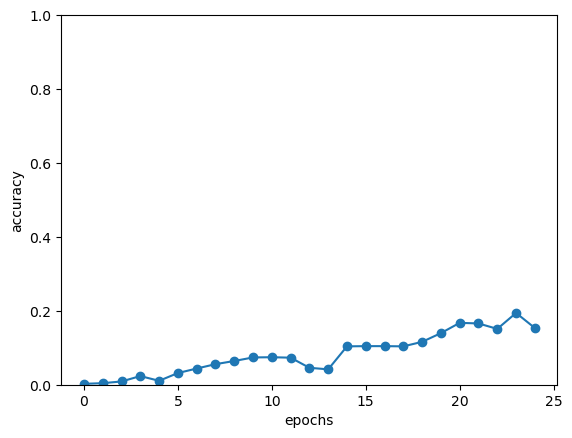

In [9]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = False
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]


vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0


model = Seq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

# 7.4 seq2seq 개선

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.21
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.97
| epoch 1 |  iter 81 / 351 | time 5[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 7[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 8[s] | loss 1.85
| epoch 1 |  iter 161 / 351 | time 10[s] | loss 1.85
| epoch 1 |  iter 181 / 351 | time 11[s] | loss 1.84
| epoch 1 |  iter 201 / 351 | time 13[s] | loss 1.84
| epoch 1 |  iter 221 / 351 | time 14[s] | loss 1.82
| epoch 1 |  iter 241 / 351 | time 15[s] | loss 1.78
| epoch 1 |  iter 261 / 351 | time 17[s] | loss 1.77
| epoch 1 |  iter 281 / 351 | time 18[s] | loss 1.77
| epoch 1 |  iter 301 / 351 | time 19[s] | loss 1.76
| epoch 1 |  iter 321 / 351 | time 21[s] | loss 1.76
| epoch 1 |  iter 341 / 351 | time 22[s] | loss 1.76
Q 207+640
T 847 
X 1000
---
Q 694+544
T 1238
X 1000
---
Q 86

| epoch 7 |  iter 321 / 351 | time 20[s] | loss 0.69
| epoch 7 |  iter 341 / 351 | time 21[s] | loss 0.68
Q 207+640
T 847 
O 847 
---
Q 694+544
T 1238
X 1237
---
Q 86+687 
T 773 
X 772 
---
Q 575+15 
T 590 
X 589 
---
Q 909+60 
T 969 
X 968 
---
Q 56+918 
T 974 
X 976 
---
Q 38+792 
T 830 
X 827 
---
Q 58+421 
T 479 
X 475 
---
Q 122+89 
T 211 
X 212 
---
Q 636+200
T 836 
X 837 
---
val acc 16.040%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.67
| epoch 8 |  iter 21 / 351 | time 1[s] | loss 0.67
| epoch 8 |  iter 41 / 351 | time 2[s] | loss 0.68
| epoch 8 |  iter 61 / 351 | time 3[s] | loss 0.67
| epoch 8 |  iter 81 / 351 | time 5[s] | loss 0.66
| epoch 8 |  iter 101 / 351 | time 6[s] | loss 0.64
| epoch 8 |  iter 121 / 351 | time 7[s] | loss 0.65
| epoch 8 |  iter 141 / 351 | time 8[s] | loss 0.65
| epoch 8 |  iter 161 / 351 | time 10[s] | loss 0.63
| epoch 8 |  iter 181 / 351 | time 11[s] | loss 0.63
| epoch 8 |  iter 201 / 351 | time 12[s] | loss 0.63
| epoch 8 |  iter 221 / 351 |

| epoch 14 |  iter 121 / 351 | time 7[s] | loss 0.41
| epoch 14 |  iter 141 / 351 | time 8[s] | loss 0.41
| epoch 14 |  iter 161 / 351 | time 10[s] | loss 0.41
| epoch 14 |  iter 181 / 351 | time 11[s] | loss 0.41
| epoch 14 |  iter 201 / 351 | time 12[s] | loss 0.40
| epoch 14 |  iter 221 / 351 | time 14[s] | loss 0.41
| epoch 14 |  iter 241 / 351 | time 15[s] | loss 0.41
| epoch 14 |  iter 261 / 351 | time 16[s] | loss 0.41
| epoch 14 |  iter 281 / 351 | time 17[s] | loss 0.42
| epoch 14 |  iter 301 / 351 | time 18[s] | loss 0.41
| epoch 14 |  iter 321 / 351 | time 20[s] | loss 0.41
| epoch 14 |  iter 341 / 351 | time 21[s] | loss 0.41
Q 207+640
T 847 
X 845 
---
Q 694+544
T 1238
X 1239
---
Q 86+687 
T 773 
X 772 
---
Q 575+15 
T 590 
O 590 
---
Q 909+60 
T 969 
O 969 
---
Q 56+918 
T 974 
X 973 
---
Q 38+792 
T 830 
X 829 
---
Q 58+421 
T 479 
O 479 
---
Q 122+89 
T 211 
O 211 
---
Q 636+200
T 836 
X 834 
---
val acc 38.120%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.41
| epoch

val acc 45.660%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.34
| epoch 21 |  iter 21 / 351 | time 1[s] | loss 0.33
| epoch 21 |  iter 41 / 351 | time 2[s] | loss 0.34
| epoch 21 |  iter 61 / 351 | time 3[s] | loss 0.34
| epoch 21 |  iter 81 / 351 | time 5[s] | loss 0.32
| epoch 21 |  iter 101 / 351 | time 6[s] | loss 0.32
| epoch 21 |  iter 121 / 351 | time 7[s] | loss 0.33
| epoch 21 |  iter 141 / 351 | time 9[s] | loss 0.33
| epoch 21 |  iter 161 / 351 | time 10[s] | loss 0.32
| epoch 21 |  iter 181 / 351 | time 11[s] | loss 0.32
| epoch 21 |  iter 201 / 351 | time 12[s] | loss 0.32
| epoch 21 |  iter 221 / 351 | time 14[s] | loss 0.32
| epoch 21 |  iter 241 / 351 | time 15[s] | loss 0.34
| epoch 21 |  iter 261 / 351 | time 16[s] | loss 0.34
| epoch 21 |  iter 281 / 351 | time 17[s] | loss 0.34
| epoch 21 |  iter 301 / 351 | time 19[s] | loss 0.34
| epoch 21 |  iter 321 / 351 | time 20[s] | loss 0.34
| epoch 21 |  iter 341 / 351 | time 21[s] | loss 0.32
Q 207+640
T 847 
O 847 
--

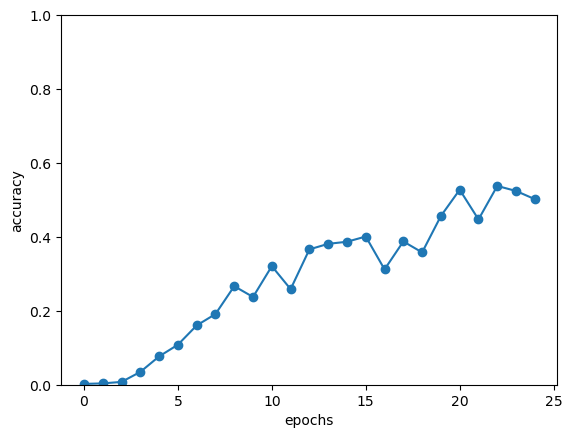

In [10]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_reverse = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list_reverse.append(acc)
    print('val acc %.3f%%' % (acc * 100))

x = np.arange(len(acc_list_reverse))
plt.plot(x, acc_list_reverse, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

In [11]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.47
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 4[s] | loss 1.98
| epoch 1 |  iter 81 / 351 | time 5[s] | loss 1.90
| epoch 1 |  iter 101 / 351 | time 7[s] | loss 1.84
| epoch 1 |  iter 121 / 351 | time 8[s] | loss 1.81
| epoch 1 |  iter 141 / 351 | time 10[s] | loss 1.79
| epoch 1 |  iter 161 / 351 | time 11[s] | loss 1.78
| epoch 1 |  iter 181 / 351 | time 12[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 14[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 15[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 16[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 17[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 19[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 20[s] | loss 1.75
| epoch 1 |  iter 321 / 351 | time 21[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 23[s] | loss 1.74
Q 207+640
T 847 
X 1034
---
Q 694+544
T 1238
X 1000
---
Q 8

| epoch 7 |  iter 301 / 351 | time 20[s] | loss 0.58
| epoch 7 |  iter 321 / 351 | time 21[s] | loss 0.58
| epoch 7 |  iter 341 / 351 | time 23[s] | loss 0.56
Q 207+640
T 847 
X 845 
---
Q 694+544
T 1238
X 1242
---
Q 86+687 
T 773 
O 773 
---
Q 575+15 
T 590 
O 590 
---
Q 909+60 
T 969 
X 970 
---
Q 56+918 
T 974 
X 975 
---
Q 38+792 
T 830 
X 826 
---
Q 58+421 
T 479 
O 479 
---
Q 122+89 
T 211 
O 211 
---
Q 636+200
T 836 
O 836 
---
val acc 35.400%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.53
| epoch 8 |  iter 21 / 351 | time 1[s] | loss 0.54
| epoch 8 |  iter 41 / 351 | time 2[s] | loss 0.52
| epoch 8 |  iter 61 / 351 | time 4[s] | loss 0.51
| epoch 8 |  iter 81 / 351 | time 5[s] | loss 0.50
| epoch 8 |  iter 101 / 351 | time 7[s] | loss 0.50
| epoch 8 |  iter 121 / 351 | time 8[s] | loss 0.48
| epoch 8 |  iter 141 / 351 | time 10[s] | loss 0.48
| epoch 8 |  iter 161 / 351 | time 11[s] | loss 0.46
| epoch 8 |  iter 181 / 351 | time 12[s] | loss 0.44
| epoch 8 |  iter 201 / 351 

| epoch 14 |  iter 101 / 351 | time 7[s] | loss 0.06
| epoch 14 |  iter 121 / 351 | time 8[s] | loss 0.06
| epoch 14 |  iter 141 / 351 | time 10[s] | loss 0.06
| epoch 14 |  iter 161 / 351 | time 11[s] | loss 0.06
| epoch 14 |  iter 181 / 351 | time 12[s] | loss 0.05
| epoch 14 |  iter 201 / 351 | time 14[s] | loss 0.06
| epoch 14 |  iter 221 / 351 | time 15[s] | loss 0.05
| epoch 14 |  iter 241 / 351 | time 17[s] | loss 0.05
| epoch 14 |  iter 261 / 351 | time 18[s] | loss 0.06
| epoch 14 |  iter 281 / 351 | time 19[s] | loss 0.06
| epoch 14 |  iter 301 / 351 | time 21[s] | loss 0.06
| epoch 14 |  iter 321 / 351 | time 22[s] | loss 0.06
| epoch 14 |  iter 341 / 351 | time 24[s] | loss 0.06
Q 207+640
T 847 
O 847 
---
Q 694+544
T 1238
O 1238
---
Q 86+687 
T 773 
O 773 
---
Q 575+15 
T 590 
O 590 
---
Q 909+60 
T 969 
O 969 
---
Q 56+918 
T 974 
O 974 
---
Q 38+792 
T 830 
O 830 
---
Q 58+421 
T 479 
O 479 
---
Q 122+89 
T 211 
O 211 
---
Q 636+200
T 836 
O 836 
---
val acc 94.600%
| ep

Q 207+640
T 847 
O 847 
---
Q 694+544
T 1238
O 1238
---
Q 86+687 
T 773 
O 773 
---
Q 575+15 
T 590 
O 590 
---
Q 909+60 
T 969 
O 969 
---
Q 56+918 
T 974 
O 974 
---
Q 38+792 
T 830 
O 830 
---
Q 58+421 
T 479 
O 479 
---
Q 122+89 
T 211 
O 211 
---
Q 636+200
T 836 
O 836 
---
val acc 96.800%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.01
| epoch 21 |  iter 21 / 351 | time 1[s] | loss 0.02
| epoch 21 |  iter 41 / 351 | time 2[s] | loss 0.03
| epoch 21 |  iter 61 / 351 | time 4[s] | loss 0.02
| epoch 21 |  iter 81 / 351 | time 5[s] | loss 0.03
| epoch 21 |  iter 101 / 351 | time 7[s] | loss 0.03
| epoch 21 |  iter 121 / 351 | time 8[s] | loss 0.03
| epoch 21 |  iter 141 / 351 | time 9[s] | loss 0.04
| epoch 21 |  iter 161 / 351 | time 11[s] | loss 0.04
| epoch 21 |  iter 181 / 351 | time 12[s] | loss 0.04
| epoch 21 |  iter 201 / 351 | time 13[s] | loss 0.04
| epoch 21 |  iter 221 / 351 | time 15[s] | loss 0.03
| epoch 21 |  iter 241 / 351 | time 16[s] | loss 0.03
| epoch 21 |  it

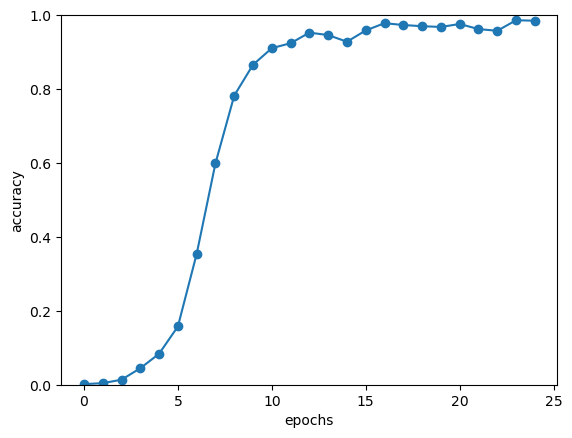

In [13]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
    

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_peeky = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list_peeky.append(acc)
    print('val acc %.3f%%' % (acc * 100))

x = np.arange(len(acc_list_peeky))
plt.plot(x, acc_list_peeky, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

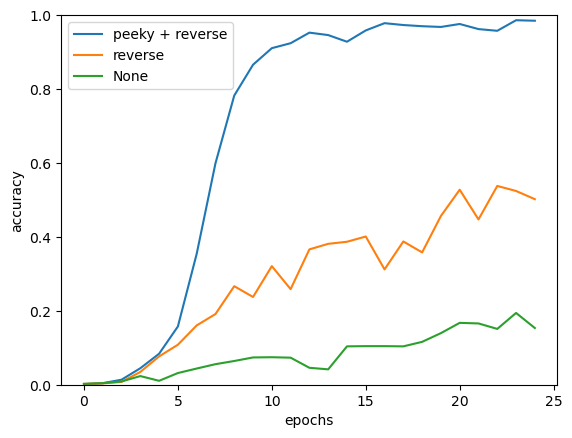

In [15]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list_peeky, label = 'peeky + reverse')
plt.plot(x, acc_list_reverse, label = 'reverse')
plt.plot(x, acc_list, label = 'None')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0, 1.0)
plt.show()

# 7.5 seq2seq를 이용하는 애플리케이션